# Caso 2: Cluster y DBSCAN

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn import cluster
from sklearn.cluster import DBSCAN, KMeans

In [2]:
# Cargar el archivo CSV
df = pd.read_csv("Comercio Electrónico Evaluación.csv")

In [3]:
# Mostrar las primeras filas
df.head(7)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
0,2425083,49125,1,2,18,NaN,17,1,0,13,pantry,baking ingredients
1,2425083,49125,1,2,18,NaN,91,2,0,16,dairy eggs,soy lactosefree
2,2425083,49125,1,2,18,NaN,36,3,0,16,dairy eggs,butter
3,2425083,49125,1,2,18,NaN,83,4,0,4,produce,fresh vegetables
4,2425083,49125,1,2,18,NaN,83,5,0,4,produce,fresh vegetables
5,2425083,49125,1,2,18,NaN,91,6,0,16,dairy eggs,soy lactosefree
6,2425083,49125,1,2,18,NaN,120,7,0,16,dairy eggs,yogurt
7,2425083,49125,1,2,18,NaN,59,8,0,15,canned goods,canned meals beans
8,2425083,49125,1,2,18,NaN,35,9,0,12,meat seafood,poultry counter
9,1944304,162867,1,3,17,NaN,37,1,0,1,frozen,ice cream ice


El archivo contiene datos transaccionales con las siguientes columnas:

- **ID de la orden (order_id):** Identificador único para cada transacción.
- **ID del usuario (user_id):** Identifica al cliente que realizó la compra.
- **Número de orden (order_number):** Indica el número de la orden en el historial del cliente.
- **Día de la semana (order_dow):** Día de la semana en que se realizó la orden.
- **Hora del día (order_hour_of_day):** Hora exacta de la transacción.
- **Días desde la última orden (days_since_prior_order):** Tiempo desde la última compra realizada por el cliente.
- **ID y Nombre del producto (product_id y product_name):** Identificadores y nombres de los productos comprados.
- **Orden en el carrito (add_to_cart_order):** Secuencia en la que los productos fueron añadidos al carrito.
- **Producto reordenado (reordered):** Indica si el producto fue comprado anteriormente (1) o no (0).
- **ID y Nombre del Departamento (department_id y department):** Identificador y Categoría general a la que pertenece cada producto.

## 1. Análisis exploratorio de datos
El análisis de datos inicial es fundamental para entender las características y la estructura del dataset. Este paso ayudará a identificar patrones, valores atípicos y posibles problemas que puedan necesitar atención antes de aplicar DBSCAN.

In [4]:
# Mostrar información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019501 entries, 0 to 2019500
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_order       int64  
 8   reordered               int64  
 9   department_id           int64  
 10  department              object 
 11  product_name            object 
dtypes: float64(1), int64(9), object(2)
memory usage: 184.9+ MB


Resumen de las observaciones:

- 2,019,501 filas y 12 columnas.
- Las columnas numéricas están correctamente categorizadas como int64 o float64.
- Las columnas de texto están en formato object.

In [5]:
# Estadísticas descriptivas de las columnas numéricas
print("Estadísticas descriptivas:")
df.describe()

Estadísticas descriptivas:


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id
count,2.019501e+06,2.019501e+06,2.019501e+06,2.019501e+06,2.019501e+06,1.895159e+06,2.019501e+06,2.019501e+06,2.019501e+06,2.019501e+06
mean,1.707013e+06,1.030673e+05,1.715138e+01,2.735367e+00,1.343948e+01,1.138603e+01,7.120590e+01,8.363173e+00,5.897427e-01,9.928349e+00
std,9.859832e+05,5.949117e+04,1.752576e+01,2.093882e+00,4.241008e+00,8.970980e+00,3.820727e+01,7.150059e+00,4.918804e-01,6.282933e+00
min,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,8.526490e+05,5.158400e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,3.100000e+01,3.000000e+00,0.000000e+00,4.000000e+00
50%,1.705004e+06,1.026900e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,8.300000e+01,6.000000e+00,1.000000e+00,9.000000e+00
75%,2.559031e+06,1.546000e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,1.070000e+02,1.100000e+01,1.000000e+00,1.600000e+01
max,3.421080e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,1.340000e+02,1.370000e+02,1.000000e+00,2.100000e+01


La tabla de estadísticas descriptivas muestra un conjunto de datos con un gran volumen de transacciones y usuarios, donde la mayoría de las compras se realizan entre el miércoles y el jueves, en promedio alrededor de la 1:30 p.m. Además, un 59% de los productos comprados son reordenados y los usuarios tienden a realizar compras recurrentes cada 11 días.

In [6]:
# Verificar valores nulos en las columnas
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    124342
product_id                     0
add_to_cart_order              0
reordered                      0
department_id                  0
department                     0
product_name                   0
dtype: int64


La columna days_since_prior_order es la única que contiene valores nulos (124,342 valores).

In [7]:
# Verificar si hay columnas con valores idénticos
columnas_identicas = []

# Comparar cada columna con el resto
for i, col in enumerate(df.columns):
    for other_col in df.columns[i+1:]:
        if df[col].equals(df[other_col]):
            columnas_identicas.append((col, other_col))

# Mostrar columnas duplicadas, si existen
if columnas_identicas:
    print("Columnas con valores idénticos:")
    for dup in columnas_identicas:
        print(f"{dup[0]} es idéntica a {dup[1]}")
else:
    print("No hay columnas con los mismos valores en el DataFrame.")

No hay columnas con los mismos valores en el DataFrame.


In [8]:
# Verificar si hay filas duplicadas
filas_duplicadas = df[df.duplicated()]

# Mostrar detalles de filas duplicadas
if not filas_duplicadas.empty:
    print(f"Se encontraron {len(filas_duplicadas)} filas duplicadas.")
    print("Primeras filas duplicadas encontradas:")
    print(filas_duplicadas.head())
else:
    print("No se encontraron filas duplicadas en el DataFrame.")

No se encontraron filas duplicadas en el DataFrame.


## 2. Limpieza de datos
Se imputan los valores nulos de 'days_since_prior_order' con 0 (representando clientes sin historial previo)

In [9]:
# Imputar valores nulos en 'days_since_prior_order' con 0
df['days_since_prior_order'] = df['days_since_prior_order'].fillna(0)

# Convertir 'days_since_prior_order' a tipo 'int'
df = df.astype({'days_since_prior_order': int})

# Verificar valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
order_id                  0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
department_id             0
department                0
product_name              0
dtype: int64


## 3. Crear variables derivadas (para análisis de clustering)

### 3.1. Calcular la frecuencia de compras por cliente:

Aquí se calcula la frecuencia de compras por cliente, es decir, el número de compras únicas realizadas por cada usuario. Esto puede ser útil para entender el comportamiento de compra de los usuarios a lo largo del tiempo.

In [10]:
frecuencia = df.groupby('user_id')['order_id'].nunique()
frecuencia = frecuencia.reset_index().rename(columns={'order_id': 'Frecuencia'})
frecuencia['user_id'] = frecuencia['user_id'].astype('object')

### 3.2. Calcular el total de productos comprados por cliente

Este cálculo muestra el total de productos comprados por cada cliente, sumando la cantidad de productos añadidos al carrito. Es una medida que puede ayudar a evaluar el volumen de compra de cada cliente.

In [11]:
total_compras = df.groupby('user_id')['add_to_cart_order'].sum()  # Suma los productos añadidos al carrito por cliente
total_compras = total_compras.reset_index().rename(columns={'add_to_cart_order': 'TotalCompras'})
total_compras['user_id'] = total_compras['user_id'].astype('object')

### 3.3. Calcular los días desde la última compra para cada cliente

Este paso calcula el número de días desde la última compra de cada cliente, usando el valor máximo de 'days_since_prior_order' por cliente. En caso de que no haya datos (por ejemplo, nuevos clientes), se imputa con 0. Este dato es clave para segmentar a los clientes en función de su recencia de compra.

In [12]:
ultimo_dia = df.groupby('user_id')['days_since_prior_order'].max()  # Tomamos el máximo de días
ultimo_dia = ultimo_dia.reset_index().rename(columns={'days_since_prior_order': 'UltimoCompra'})
ultimo_dia['UltimoCompra'] = ultimo_dia['UltimoCompra'].fillna(0)  # Rellenar valores nulos con 0 (en caso de nuevos clientes)

Las tres métricas calculadas (frecuencia de compras, total de productos comprados, y días desde la última compra) se fusionan en un solo DataFrame llamado df_clientes. Esto facilita el análisis posterior de los clientes.

In [13]:
# Fusionar las características en un solo dataframe
df_clientes = pd.merge(frecuencia, total_compras, on='user_id', how='inner')
df_clientes = pd.merge(df_clientes, ultimo_dia, on='user_id', how='inner')

In [14]:
# Revisar las primeras filas del dataframe final
df_clientes.head(7)

,user_id,Frecuencia,TotalCompras,UltimoCompra
0,2,2,36,10
1,3,3,75,20
2,7,1,300,30
3,10,1,465,14
4,11,1,66,30
5,13,1,55,7
6,17,1,15,4


## 4. Normalización de datos
Escalamos el nuevo dataframe usando StandardScaler para normalizar los datos.

In [15]:
# Normalización de las características
scaler = StandardScaler()
df_clientes_scaled = scaler.fit_transform(df_clientes[['Frecuencia', 'TotalCompras', 'UltimoCompra']])

# Convertimos el array escalado de vuelta a un DataFrame
df_clientes_scaled = pd.DataFrame(df_clientes_scaled, columns=['Frecuencia', 'TotalCompras', 'UltimoCompra'])

## 5. DBSCAN
Se aplica el algoritmo DBSCAN para realizar el clustering de los clientes. DBSCAN es adecuado para identificar clústeres de alta densidad en datos, y también es capaz de detectar puntos ruidosos que no se agrupan con otros puntos. El parámetro eps define el radio de vecindad, y min_samples indica el número mínimo de puntos requeridos para formar un clúster.

In [16]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=12)
df_clientes['Cluster_DBSCAN'] = dbscan.fit_predict(df_clientes_scaled)

# Ver los resultados de DBSCAN
n_clusters_dbscan = len(set(df_clientes['Cluster_DBSCAN'])) - (1 if -1 in df_clientes['Cluster_DBSCAN'].values else 0)
n_noise = list(df_clientes['Cluster_DBSCAN']).count(-1)

print(f"Cantidad de clusters encontrados: {n_clusters_dbscan}")
print(f"Puntos clasificados como ruido: {n_noise}")

Cantidad de clusters encontrados: 12
Puntos clasificados como ruido: 322


### Visualización de los resultados de DBSCAN

#### Visualización 1: TotalCompras vs. Frecuencia
Se genera un gráfico de dispersión para visualizar cómo se agrupan los clientes en función de su total de compras y frecuencia de compras. Los puntos se colorean según el cluster al que pertenecen, lo que ayuda a identificar visualmente los grupos formados por DBSCAN.

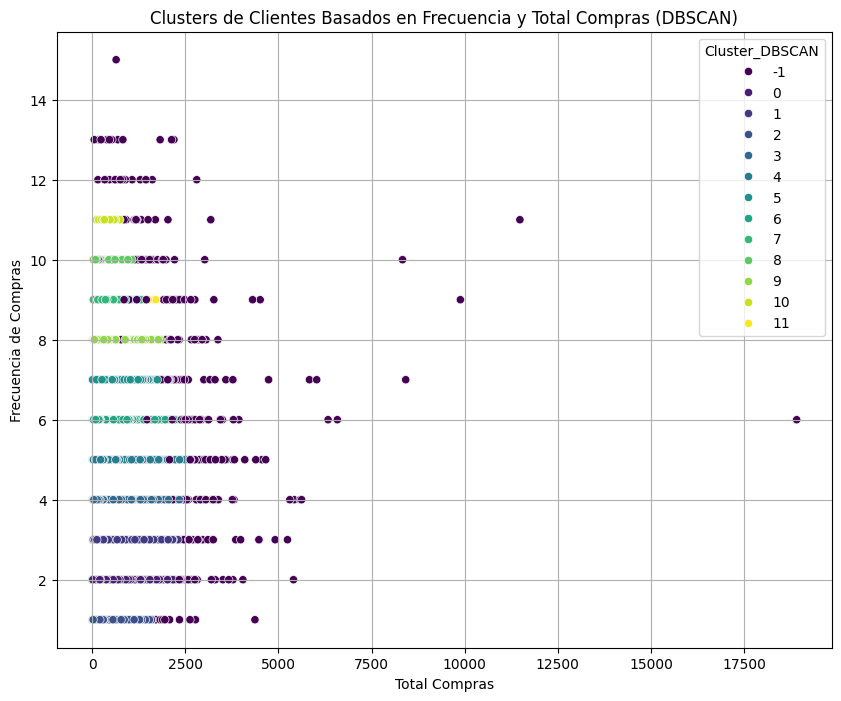

In [17]:
# Visualización de los resultados de DBSCAN (TotalCompras y Frecuencia)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_clientes['TotalCompras'], y=df_clientes['Frecuencia'], hue=df_clientes['Cluster_DBSCAN'], palette="viridis", legend='full')
plt.title('Clusters de Clientes Basados en Frecuencia y Total Compras (DBSCAN)')
plt.xlabel('Total Compras')
plt.ylabel('Frecuencia de Compras')
plt.grid(True)
plt.show()

Se observa que la mayoría de los clusters están concentrados en clientes con frecuencia baja o media (entre 2 y 10 compras) y montos acumulados relativamente bajos (menos de 5000). Algunos puntos aislados (cluster -1) destacan por montos significativamente altos (más de 10,000) o frecuencias muy elevadas, indicando comportamientos atípicos. Esto sugiere que la mayoría de los clientes tienen patrones regulares, mientras que los outliers podrían requerir un análisis más detallado.

#### Visualización 2: TotalCompras vs. Días Desde Última Compra
Este gráfico muestra la relación entre los días desde la última compra y el total de compras. Esto permite ver cómo los clientes se agrupan no solo por la frecuencia con que compran, sino también por la recencia de sus compras, una métrica importante para segmentar clientes.

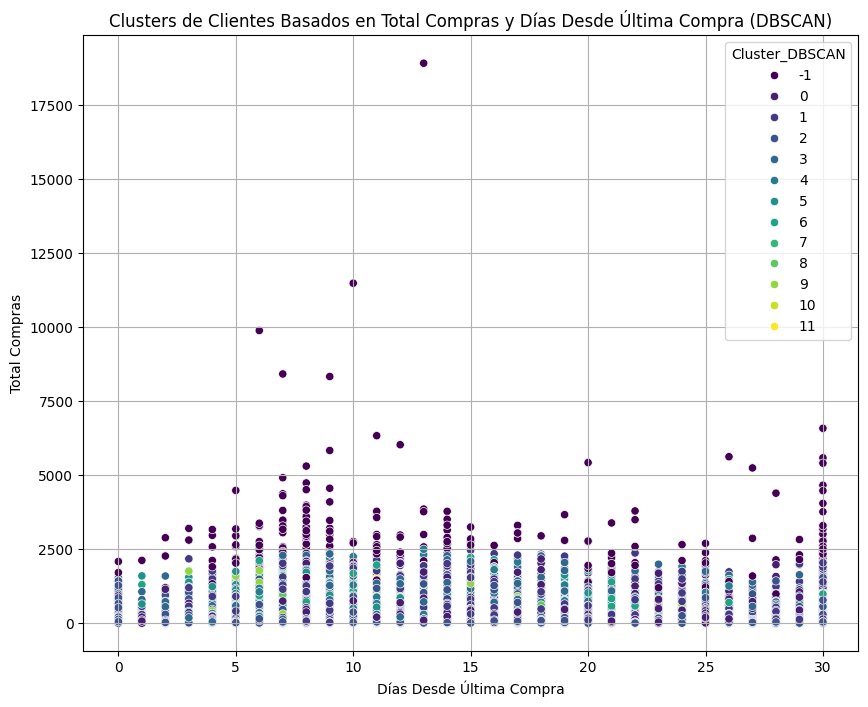

In [18]:
# Visualización de los resultados (TotalCompras y UltimoCompra)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_clientes['UltimoCompra'], y=df_clientes['TotalCompras'], hue=df_clientes['Cluster_DBSCAN'], palette="viridis", legend='full')
plt.title('Clusters de Clientes Basados en Total Compras y Días Desde Última Compra (DBSCAN)')
plt.xlabel('Días Desde Última Compra')
plt.ylabel('Total Compras')
plt.grid(True)
plt.show()

Del gráfico se deduce que la mayoría de los clientes se agrupan en clusters cercanos al eje inferior (bajo total de compras) y están distribuidos regularmente en los días desde su última compra. Además, hay algunos puntos aislados (ruido, cluster -1), que representan clientes con comportamientos atípicos o extremos, como compras significativamente altas. Esto sugiere que la mayoría de los clientes tienen un comportamiento estándar, mientras que unos pocos destacan por su actividad.

#### Visualización 3: Frecuencia vs. Días Desde Última Compra
Este gráfico muestra la relación entre frecuencia de compras y días desde la última compra. Visualizar estos datos es útil para identificar patrones y segmentar a los clientes en base a su comportamiento de compra y recencia, lo que puede ser clave para estrategias de marketing personalizadas.

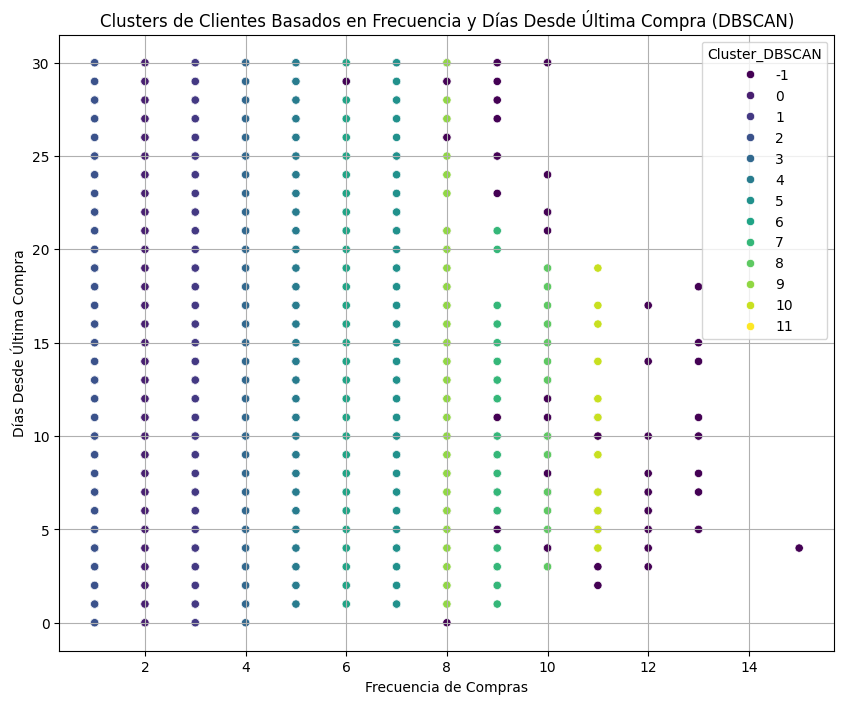

In [19]:
# Visualización de los resultados (Frecuencia y UltimoCompra)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_clientes['Frecuencia'], y=df_clientes['UltimoCompra'], hue=df_clientes['Cluster_DBSCAN'], palette="viridis", legend='full')
plt.title('Clusters de Clientes Basados en Frecuencia y Días Desde Última Compra (DBSCAN)')
plt.xlabel('Frecuencia de Compras')
plt.ylabel('Días Desde Última Compra')
plt.grid(True)
plt.show()

Se observa que los clusters se distribuyen en intervalos regulares de frecuencia, indicando grupos bien definidos de clientes con hábitos similares. La mayoría de los clientes tienen frecuencias entre 2 y 10 compras, distribuidos de forma consistente a lo largo de los días desde su última transacción. Los puntos aislados (cluster -1) representan clientes atípicos, como aquellos con frecuencias altas o periodos inusualmente largos desde su última compra, lo que puede sugerir patrones únicos o inusuales.

### Distribución de Clusters de DBSCAN
Se calcula la distribución de los clusters de DBSCAN en términos de porcentaje. Esto nos permite entender la proporción de clientes asignados a cada clúster, y detectar si algún clúster tiene una cantidad anómala de clientes, o si la mayoría de los puntos son clasificados como ruido (-1).

In [20]:
# Revisar la distribución de los clusters de DBSCAN (porcentaje de clientes en cada cluster)
cluster_counts_dbscan = df_clientes['Cluster_DBSCAN'].value_counts(normalize=True) * 100
print("\nDistribución de Clusters de DBSCAN en porcentaje:")
print(cluster_counts_dbscan)


Distribución de Clusters de DBSCAN en porcentaje:
Cluster_DBSCAN
 2     54.889668
 0     23.427660
 1     10.600059
 3      5.145669
 4      2.656902
 6      1.466663
 5      0.785577
 9      0.390413
-1      0.305871
 7      0.205181
 8      0.079793
 10     0.035147
 11     0.011399
Name: proportion, dtype: float64


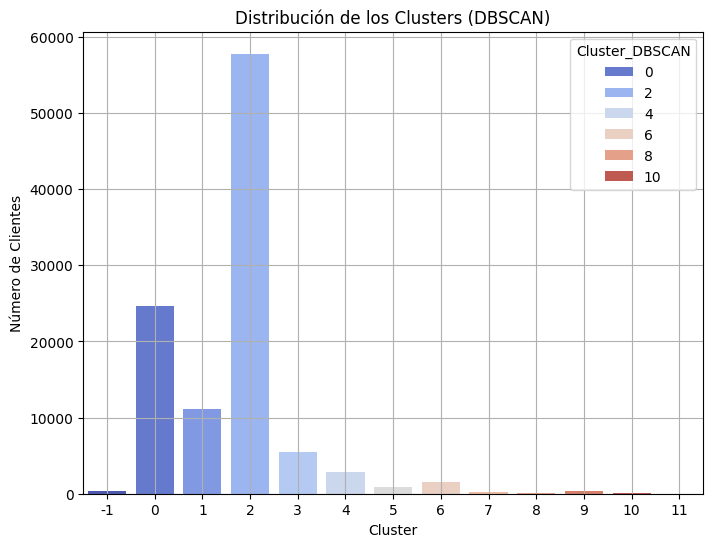

In [21]:
# Visualización de la distribución de los clusters de DBSCAN
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster_DBSCAN', data=df_clientes, hue='Cluster_DBSCAN', palette="coolwarm")
plt.title('Distribución de los Clusters (DBSCAN)')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.grid(True)
plt.show()

Este gráfico de barras muestra la distribución de los clústeres generados por DBSCAN, indicando el número de clientes en cada clúster. El color de las barras ayuda a identificar visualmente las diferentes categorías y a comprender la distribución de los puntos dentro de los clústeres.

## 6. K-Means Clustering

Distortion for 2 clusters: 233557.26121886703
Distortion for 3 clusters: 146488.41162722095
Distortion for 4 clusters: 115109.53019687906
Distortion for 5 clusters: 101439.5794739557
Distortion for 6 clusters: 93618.63539018235
Distortion for 7 clusters: 79062.69554449336
Distortion for 8 clusters: 69876.69517174849
Distortion for 9 clusters: 66116.1942866961
Distortion for 10 clusters: 58895.09566545981
Distortion for 11 clusters: 54639.05713861781
Distortion for 12 clusters: 50973.11394794198
Distortion for 13 clusters: 49017.90306849331
Distortion for 14 clusters: 47595.05398799455


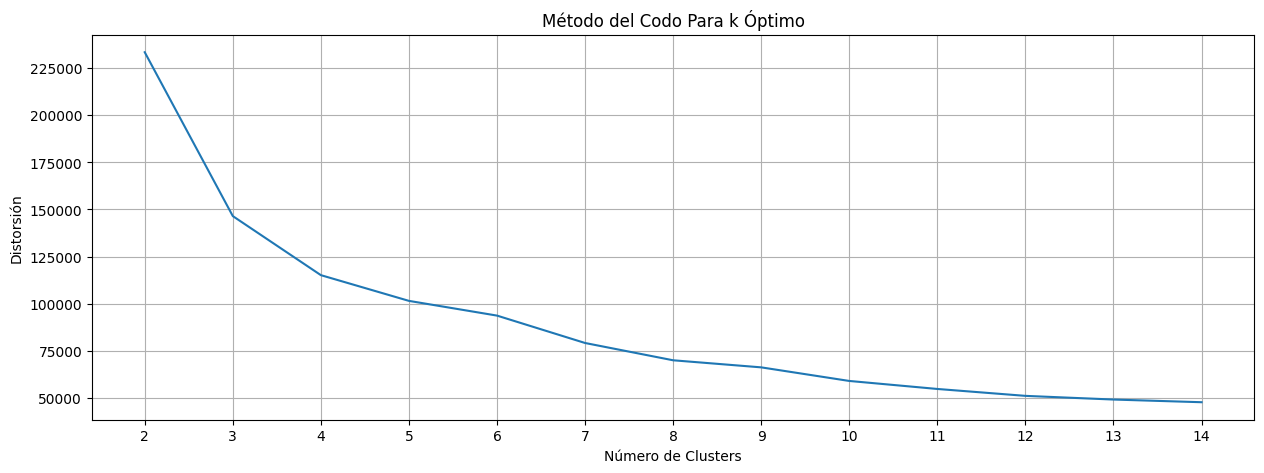

In [22]:
# Determinar la cantidad óptima de clusters utilizando el método del codo
distorsions = []
max_loop = 15

# Iterar sobre diferentes números de clusters
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_clientes_scaled)
    inertia = kmeans.inertia_
    distorsions.append(inertia)
    print(f"Distortion for {k} clusters: {inertia}")

# Graficar el número de clusters vs la distorsión para identificar el codo
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)])
plt.xlabel('Número de Clusters')
plt.ylabel('Distorsión')
plt.title('Método del Codo Para k Óptimo')
plt.grid(True)
plt.show()

Tras analizar la distorsión para diferentes valores de k en el gráfico, se observa un claro 'codo' en el número de clusters igual a 4. A partir de este valor, la disminución de la distorsión es mucho más lenta, indicando que agregar más clusters no mejora significativamente la calidad del modelo. Por lo tanto, el número óptimo de clusters para este conjunto de datos es 4.

In [ ]:
# Elegimos el número óptimo de clusters tras observar el codo
nclust = 4

# Entrenar el modelo KMeans con 4 clusters
k_means = KMeans(n_clusters=nclust)
k_means.fit(df_clientes_scaled)

# Asignar las etiquetas de los clusters al DataFrame
df_clientes = df_clientes.drop(columns=['Cluster_DBSCAN'])
df_clientes['Cluster'] = k_means.labels_

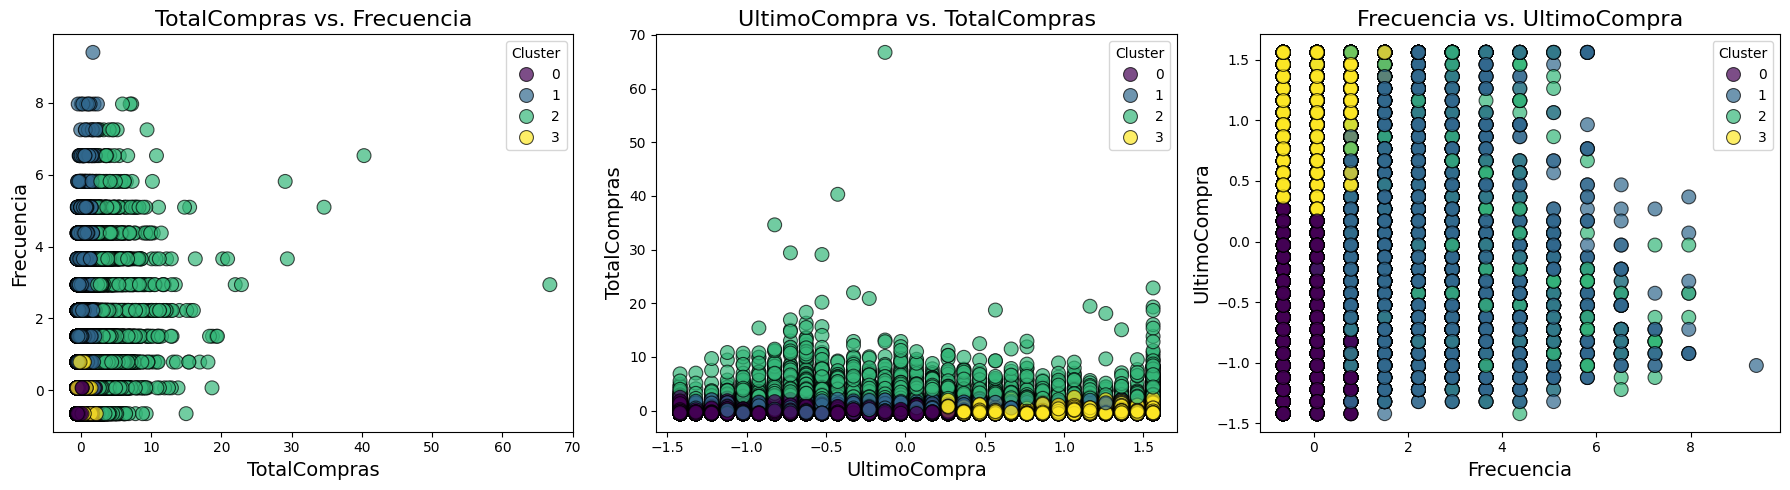

In [24]:
# Visualización de combinaciones de características con K-Means
columns = ['Frecuencia', 'TotalCompras', 'UltimoCompra']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Graficar las combinaciones de columnas
for i, ax in enumerate(axes.flatten()):
    j = (i + 1) % 3
    k = i

    # Graficar el scatterplot
    sns.scatterplot(x=df_clientes_scaled[columns[j]], y=df_clientes_scaled[columns[k]], hue=df_clientes['Cluster'], palette='viridis', ax=ax, marker='o', s=100, alpha=0.7, edgecolor='black')
    
    # Etiquetas y título
    ax.set_xlabel(columns[j], fontsize=14)
    ax.set_ylabel(columns[k], fontsize=14)
    ax.set_title(f'{columns[j]} vs. {columns[k]}', fontsize=16)

# Ajustar el diseño
plt.tight_layout()
plt.show()